In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import optuna
from prettytable import PrettyTable
import pickle
from functools import partial
import numpy as np
from tqdm import tqdm
from glob import glob
from collections.abc import Iterable
from collections import defaultdict

from utils import get_dfs, plot_metric, draw_trajectories

In [5]:
def plot_training_evolution(name, wind_dirs=[45, 90, 135, 180, 225, 270, 315], model_folder=None, eval=True, show_reward=False):
  def extract_step(filename):
    res = re.search(rf'{name}-(\d+)', filename)
    return int(res.group(1))

  def extract_env(filename):
    res = re.search(r'-(\d+)/0/', filename)
    return int(res.group(1))

  if model_folder is None:
    model_folder = name

  files = glob(f'../runs/{name}-*')
  files = sorted(files, key=extract_step)
  if len(files) == 0:
    files = glob(f'../runs/{name}')

  print(f'Found {len(files)} files')

  folder = 'eval' if eval else 'train'

  by_wind = defaultdict(list)
  by_step = defaultdict(list)
  steps = set()
  for i, file in enumerate(files):
    dfs = get_dfs(f'{file}/{folder}-*/0/')
    for key, df in dfs.items():
      wind_idx = extract_env(key)
      wind_dir = wind_dirs[wind_idx]
      step = extract_step(key)
      steps.add(step)
      score = df[f'obs/cum_obs/vmc/0'].iloc[-1]*.1
      if show_reward:
        cum_reward = df[f'reward'].sum()
      else:
        cum_reward = 0
      by_wind[wind_dir].append((score, cum_reward))
      by_step[step].append((score, cum_reward))

  args = pickle.load(open(f'../runs/{model_folder}/model_args.pkl', 'rb'))
  print('Hparams:')
  pt = PrettyTable()
  pt.field_names = ['Name', 'Value']
  for k, v in args.__dict__.items():
    if k in ['name', 'env_name', 'seed', 'reward_kwargs', 'policy_kwargs']:
      continue
    pt.add_row([k, v])
  print(pt)
  print()

  print('Mean scores by step:')
  pt = PrettyTable()
  pt.field_names = ['Step', 'Mean score', 'Mean cum. reward']
  for step, data in by_step.items():
    data = np.array(data)
    scores = data[:, 0]
    cum_reward = data[:, 1]
    pt.add_row([f'{round(step/1e3):d}K', np.mean(scores), np.mean(cum_reward)])
  print(pt)
  print()

  steps = list(sorted(steps))

  if show_reward:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
  else:
    fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
    axs = [axs]
  for wind_dir in wind_dirs:
    data = by_wind[wind_dir]
    data = np.array(data)
    scores = data[:, 0]
    cum_reward = data[:, 1]
    axs[0].plot(steps, scores, label=f'{wind_dir}°')
    if show_reward:
      axs[1].plot(steps, cum_reward)
  axs[0].set_xlabel('Training step')
  if show_reward:
    axs[1].set_xlabel('Training step')
  axs[0].set_ylabel('Cum. dist.')
  axs[0].set_ylabel('Cum. reward')
  fig.suptitle(name)
  # right legend
  fig.legend(bbox_to_anchor=(1.05, .5), loc='center left')

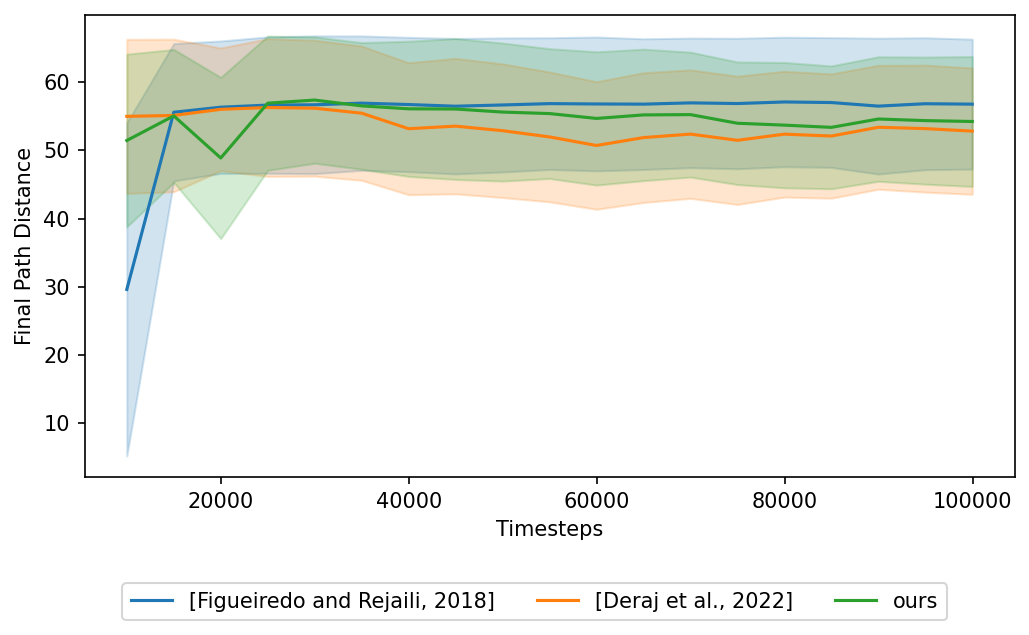

In [8]:
def metric(filename, df):
  step_idx = int(re.search(r'(\d+)(-steps|/)', filename).group(1))
  return step_idx, df['obs/cum_obs/vmc/0'].iloc[-1]*.1

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)
plot_metric(
  [
    ('09-03-linear-shape-best-s1-1-*/eval-*/0/', '[Figueiredo and Rejaili, 2018]'),
    ('09-03-real-exp-shape-best-s1-1-*/eval-*/0/', '[Deraj et al., 2022]'),
    ('09-03-custom-shape-best-s1-1-*/eval-*/0/', 'ours'),
    # ('08-31-maxminpenalize-A1-5-*/eval-*/0/', 'r2'),
    # ('08-31-maxminpenalize-A2-5-*/eval-*/0/', 'r3'),
    # ('08-31-maxminminrudder-A1-5-*/eval-*/0/', 'r2'),
    # ('08-31-maxminminrudder-A2-5-*/eval-*/0/', 'r3'),
  ],
  ax=ax,
  metric=metric,
  y_label='Final Path Distance')

plt.savefig('../assets/reward_comparison-s1.svg')

<Axes: xlabel='Timesteps', ylabel='XTE'>

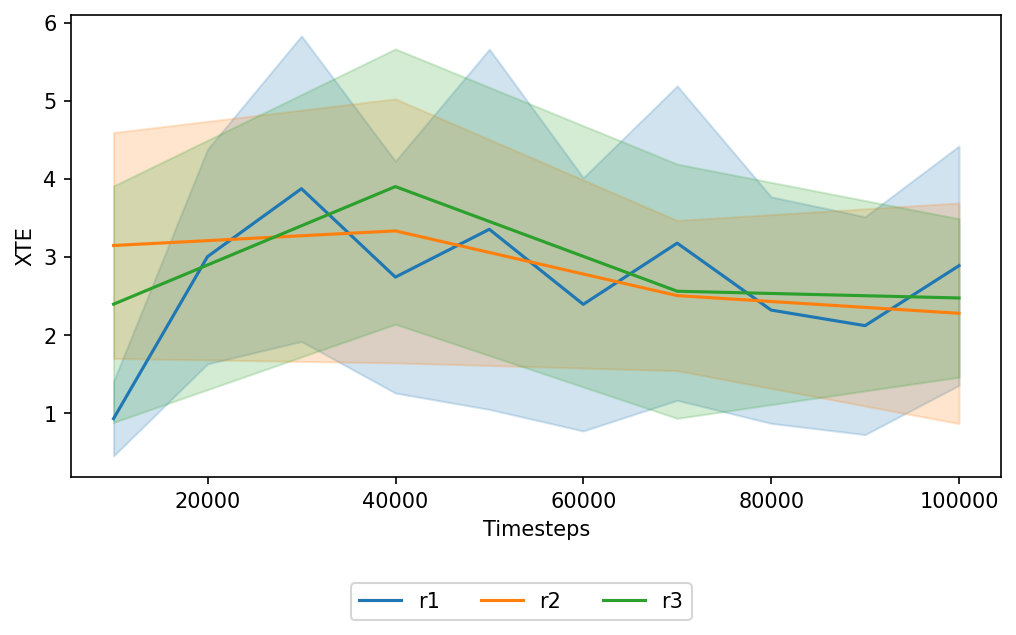

In [103]:
def metric(filename, df):
  step_idx = int(re.search(r'(\d+)(-steps|/)', filename).group(1))
  return step_idx, np.abs(df['obs/xte/0']).mean()

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)
plot_metric(
  [
    ('08-31-maxmin-A1-5-*/eval-*/0/', 'r1'),
    ('08-31-maxminminrudder-A1-5-*/eval-*/0/', 'r2'),
    ('08-31-maxminminrudder-A2-5-*/eval-*/0/', 'r3'),
  ],
  ax=ax,
  metric=metric,
  y_label='XTE')

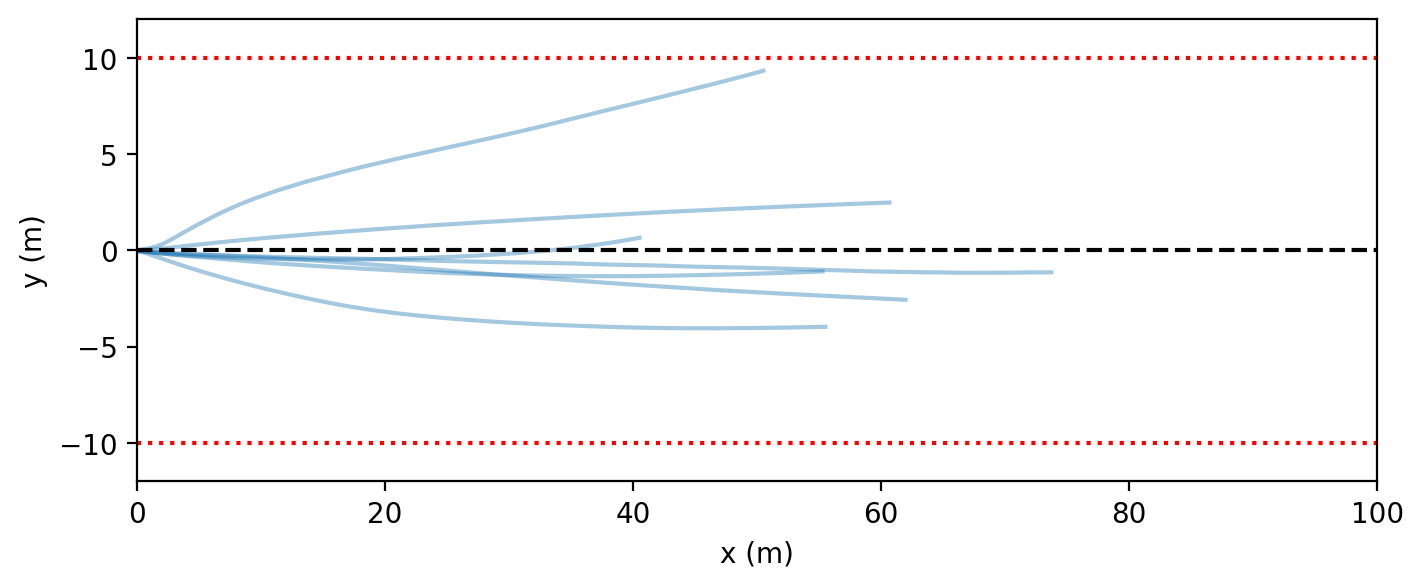

In [12]:
names = [
  ('09-03-linear-shape-best-s1-1-99960/eval-*/0/', '[Figueiredo and Rejaili, 2018]'),
  # ('09-03-real-exp-shape-best-s1-1-99960/eval-*/0/', '[Deraj et al., 2022]'),
  # ('09-03-custom-shape-best-s1-1-99960/eval-*/0/', 'ours'),
]

xte_delta = 10

fig, ax = plt.subplots(figsize=(8, 3), dpi=200)

ax.plot([0, 200], [-xte_delta, -xte_delta], 'r:')
for i, (name, label) in enumerate(names):
  color = f'C{i}'
  files = glob(f'../runs/{name}/*.csv', recursive=True)
  for file in files:
    try:
      df = pd.read_csv(file)
      ax.plot(df["obs/p_boat/0"], df["obs/p_boat/1"],
            alpha=0.4, color=color, linewidth=1.5)
    except:
      continue

for i, (_, label) in enumerate(names):
  ax.plot([], [], color=f'C{i}', label=label)

ax.plot([0, 200], [0, 0], 'k--', label='Reference path')
ax.plot([0, 200], [xte_delta, xte_delta], 'r:', label='XTE > 10m')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim(0, 100)
ax.set_ylim(-xte_delta * 1.2, xte_delta * 1.2)
# fig.legend(loc='lower center',
#             bbox_to_anchor=(.5, -.1),
#             ncol=2)
fig.savefig('../assets/trajectories-s1-lin.svg')


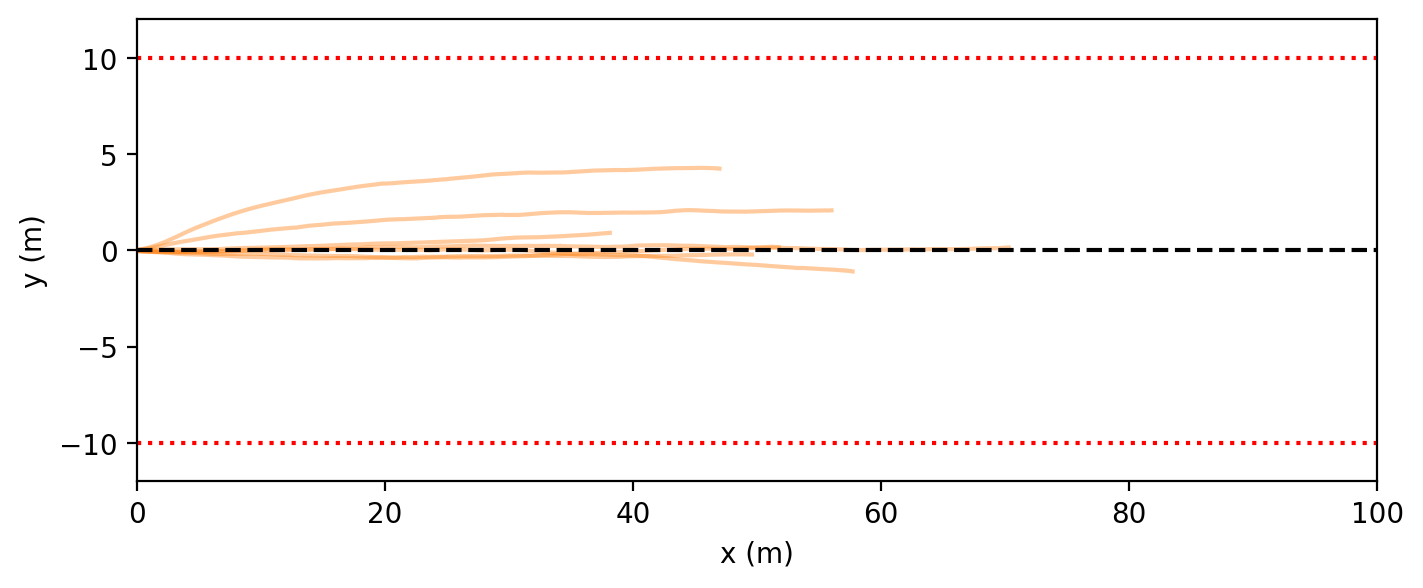

In [13]:
names = [
  # ('09-03-linear-shape-best-s1-1-99960/eval-*/0/', '[Figueiredo and Rejaili, 2018]'),
  ('09-03-real-exp-shape-best-s1-1-99960/eval-*/0/', '[Deraj et al., 2022]'),
  # ('09-03-custom-shape-best-s1-1-99960/eval-*/0/', 'ours'),
]

xte_delta = 10

fig, ax = plt.subplots(figsize=(8, 3), dpi=200)

ax.plot([0, 200], [-xte_delta, -xte_delta], 'r:')
for i, (name, label) in enumerate(names):
  color = f'C1'
  files = glob(f'../runs/{name}/*.csv', recursive=True)
  for file in files:
    try:
      df = pd.read_csv(file)
      ax.plot(df["obs/p_boat/0"], df["obs/p_boat/1"],
            alpha=0.4, color=color, linewidth=1.5)
    except:
      continue

for i, (_, label) in enumerate(names):
  ax.plot([], [], color=f'C{i}', label=label)

ax.plot([0, 200], [0, 0], 'k--', label='Reference path')
ax.plot([0, 200], [xte_delta, xte_delta], 'r:', label='XTE > 10m')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim(0, 100)
ax.set_ylim(-xte_delta * 1.2, xte_delta * 1.2)
# fig.legend(loc='lower center',
#             bbox_to_anchor=(.5, -.1),
#             ncol=2)
fig.savefig('../assets/trajectories-s1-exp.svg')


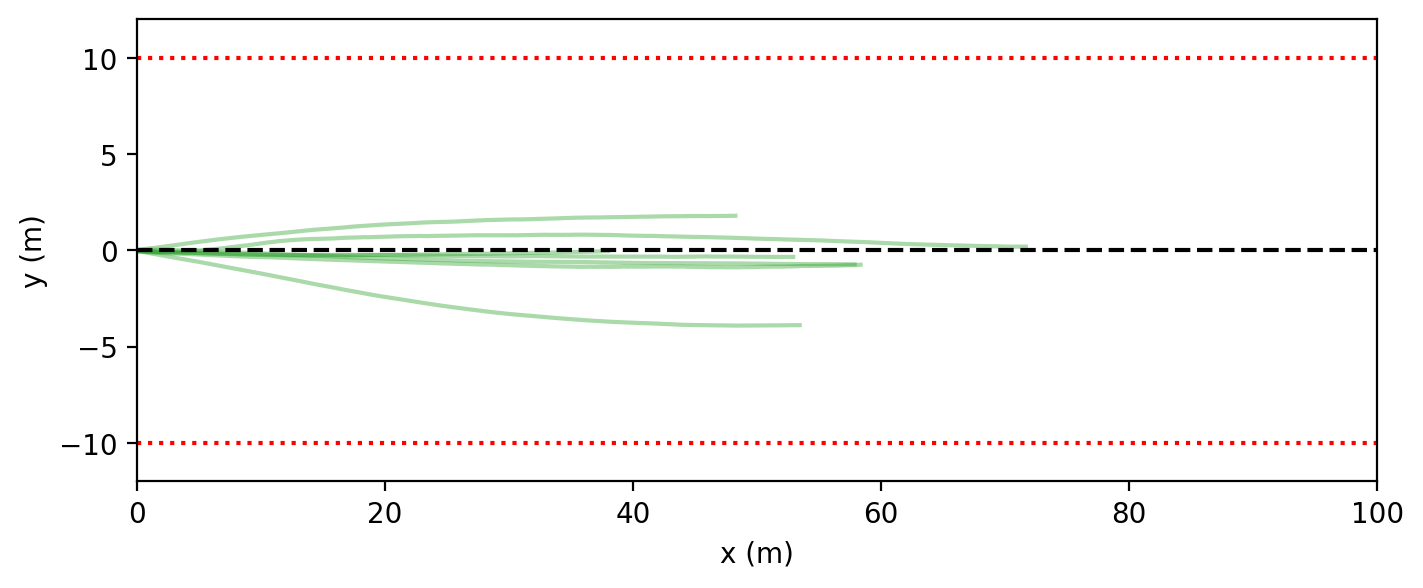

In [14]:
names = [
  # ('09-03-linear-shape-best-s1-1-99960/eval-*/0/', '[Figueiredo and Rejaili, 2018]'),
  # ('09-03-real-exp-shape-best-s1-1-99960/eval-*/0/', '[Deraj et al., 2022]'),
  ('09-03-custom-shape-best-s1-1-99960/eval-*/0/', 'ours'),
]

xte_delta = 10

fig, ax = plt.subplots(figsize=(8, 3), dpi=200)

ax.plot([0, 200], [-xte_delta, -xte_delta], 'r:')
for i, (name, label) in enumerate(names):
  color = f'C2'
  files = glob(f'../runs/{name}/*.csv', recursive=True)
  for file in files:
    try:
      df = pd.read_csv(file)
      ax.plot(df["obs/p_boat/0"], df["obs/p_boat/1"],
            alpha=0.4, color=color, linewidth=1.5)
    except:
      continue

for i, (_, label) in enumerate(names):
  ax.plot([], [], color=f'C{i}', label=label)

ax.plot([0, 200], [0, 0], 'k--', label='Reference path')
ax.plot([0, 200], [xte_delta, xte_delta], 'r:', label='XTE > 10m')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim(0, 100)
ax.set_ylim(-xte_delta * 1.2, xte_delta * 1.2)
# fig.legend(loc='lower center',
#             bbox_to_anchor=(.5, -.1),
#             ncol=2)
fig.savefig('../assets/trajectories-s1-custom.svg')


[Figueiredo and Rejaili, 2018]:   0%|          | 0/1 [00:00<?, ?it/s]

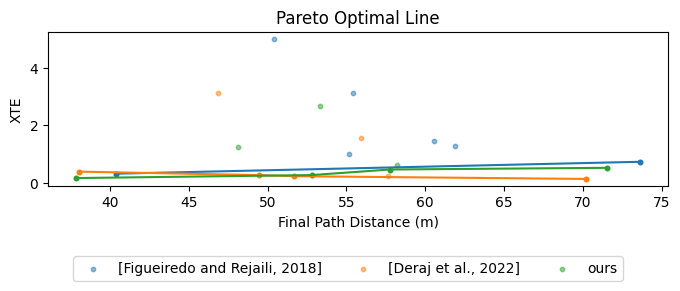

In [24]:
names = [
  ('09-03-linear-shape-best-s1-1-99960', '[Figueiredo and Rejaili, 2018]'),
  ('09-03-real-exp-shape-best-s1-1-99960', '[Deraj et al., 2022]'),
  ('09-03-custom-shape-best-s1-1-99960', 'ours'),
]
labels = ['sb3']

import pickle
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd


def plot_pareto_optimal_line(data, label=None, color=None):
  # Sort the data based on the first dimension (maximizing)
  sorted_data = data[np.argsort(data[:, 0])]
  pareto_front_left = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_left[-1][1]:
      pareto_front_left.append(point)

  sorted_data = data[np.argsort(data[:, 0])[::-1]]
  pareto_front_right = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_right[-1][1]:
      pareto_front_right.append(point)

  pareto_front = pareto_front_left[:-1] + pareto_front_right[::-1]
  pareto_front = np.array(pareto_front)
  plt.scatter(data[:, 0], data[:, 1], label=label, s=10, alpha=0.5, color=color)
  plt.scatter(pareto_front[:, 0], pareto_front[:, 1], s=10, color=color)
  plt.plot(pareto_front[:, 0], pareto_front[:, 1], color=color)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']


from collections import defaultdict
import re

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

fig = plt.figure(figsize=(8, 2))

for i, (name, label) in enumerate(names):
  files = glob(f'../runs/{name}', recursive=True)
  for file in tqdm(files, desc=label, leave=False):
    mean_xte = 0
    mean_dist = 0
    envs = glob(f'{file}/eval-*/0/*.csv')
    if len(envs) == 0:
      continue
    data = []
    for env in envs:
      try:
        df = pd.read_csv(env)
        xte = np.abs(df["obs/xte/0"]).mean()
        dist = df["obs/cum_obs/vmc/0"].iloc[-1]*.1
      except:
        continue
      data.append([dist, xte])
    data = np.array(data)
  # pickle.dump(data, open(f'../{name}_pareto.pkl', 'wb'))
    plot_pareto_optimal_line(data, label=label, color=colors[i])

# plt.ylim(0, 6)
# plt.xlim(0,56)
plt.xlabel('Final Path Distance (m)')
plt.ylabel('XTE')
plt.title('Pareto Optimal Line')
fig.legend(loc='lower center',
            bbox_to_anchor=(.5, -.4),
            ncol=len(names))

plt.show()
fig.savefig('../assets/pareto-s1-per-wind.svg')

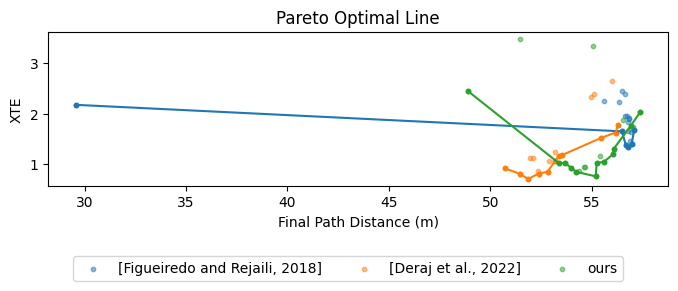

In [25]:
names = [
  ('09-03-linear-shape-best-s1-1-*', '[Figueiredo and Rejaili, 2018]'),
  ('09-03-real-exp-shape-best-s1-1-*', '[Deraj et al., 2022]'),
  ('09-03-custom-shape-best-s1-1-*', 'ours'),
]
labels = ['sb3']

import pickle
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd


def plot_pareto_optimal_line(data, label=None, color=None):
  # Sort the data based on the first dimension (maximizing)
  sorted_data = data[np.argsort(data[:, 0])]
  pareto_front_left = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_left[-1][1]:
      pareto_front_left.append(point)

  sorted_data = data[np.argsort(data[:, 0])[::-1]]
  pareto_front_right = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_right[-1][1]:
      pareto_front_right.append(point)

  pareto_front = pareto_front_left[:-1] + pareto_front_right[::-1]
  pareto_front = np.array(pareto_front)
  plt.scatter(data[:, 0], data[:, 1], label=label, s=10, alpha=0.5, color=color)
  plt.scatter(pareto_front[:, 0], pareto_front[:, 1], s=10, color=color)
  plt.plot(pareto_front[:, 0], pareto_front[:, 1], color=color)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']


from collections import defaultdict
import re

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

fig = plt.figure(figsize=(8, 2))

for i, (name, label) in enumerate(names):
  files = glob(f'../runs/{name}', recursive=True)
  data = []
  for file in tqdm(files, desc=label, leave=False):
    mean_xte = 0
    mean_dist = 0
    envs = glob(f'{file}/eval-*/0/*.csv')
    if len(envs) == 0:
      continue
    for env in envs:
      try:
        df = pd.read_csv(env)
        mean_xte += np.abs(df["obs/xte/0"]).mean()
        mean_dist += df["obs/cum_obs/vmc/0"].iloc[-1]*.1
      except:
        continue
    mean_xte /= len(envs)
    mean_dist /= len(envs)
    data.append([mean_dist, mean_xte])
  data = np.array(data)
  # pickle.dump(data, open(f'../{name}_pareto.pkl', 'wb'))
  plot_pareto_optimal_line(data, label=label, color=colors[i])

# plt.ylim(0, 6)
# plt.xlim(0,56)
plt.xlabel('Final Path Distance (m)')
plt.ylabel('XTE')
plt.title('Pareto Optimal Line')
fig.legend(loc='lower center',
            bbox_to_anchor=(.5, -.4),
            ncol=len(names))

plt.show()
fig.savefig('../assets/pareto-training.svg')

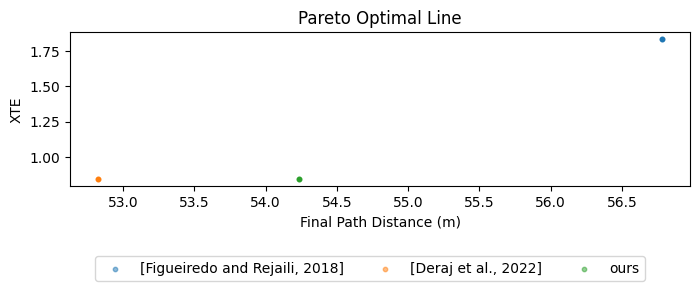

In [26]:
names = [
  ('09-03-linear-shape-best-s1-1-99960', '[Figueiredo and Rejaili, 2018]'),
  ('09-03-real-exp-shape-best-s1-1-99960', '[Deraj et al., 2022]'),
  ('09-03-custom-shape-best-s1-1-99960', 'ours'),
]
labels = ['sb3']

import pickle
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd


def plot_pareto_optimal_line(data, label=None, color=None):
  # Sort the data based on the first dimension (maximizing)
  sorted_data = data[np.argsort(data[:, 0])]
  pareto_front_left = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_left[-1][1]:
      pareto_front_left.append(point)

  sorted_data = data[np.argsort(data[:, 0])[::-1]]
  pareto_front_right = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_right[-1][1]:
      pareto_front_right.append(point)

  pareto_front = pareto_front_left[:-1] + pareto_front_right[::-1]
  pareto_front = np.array(pareto_front)
  plt.scatter(data[:, 0], data[:, 1], label=label, s=10, alpha=0.5, color=color)
  plt.scatter(pareto_front[:, 0], pareto_front[:, 1], s=10, color=color)
  plt.plot(pareto_front[:, 0], pareto_front[:, 1], color=color)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']


from collections import defaultdict
import re

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

fig = plt.figure(figsize=(8, 2))

for i, (name, label) in enumerate(names):
  files = glob(f'../runs/{name}', recursive=True)
  data = []
  for file in tqdm(files, desc=label, leave=False):
    mean_xte = 0
    mean_dist = 0
    envs = glob(f'{file}/eval-*/0/*.csv')
    if len(envs) == 0:
      continue
    for env in envs:
      try:
        df = pd.read_csv(env)
        mean_xte += np.abs(df["obs/xte/0"]).mean()
        mean_dist += df["obs/cum_obs/vmc/0"].iloc[-1]*.1
      except:
        continue
    mean_xte /= len(envs)
    mean_dist /= len(envs)
    data.append([mean_dist, mean_xte])
  data = np.array(data)
  # pickle.dump(data, open(f'../{name}_pareto.pkl', 'wb'))
  plot_pareto_optimal_line(data, label=label, color=colors[i])

# plt.ylim(0, 6)
# plt.xlim(0,56)
plt.xlabel('Final Path Distance (m)')
plt.ylabel('XTE')
plt.title('Pareto Optimal Line')
fig.legend(loc='lower center',
            bbox_to_anchor=(.5, -.4),
            ncol=len(names))

plt.show()
fig.savefig('../assets/pareto-final.svg')

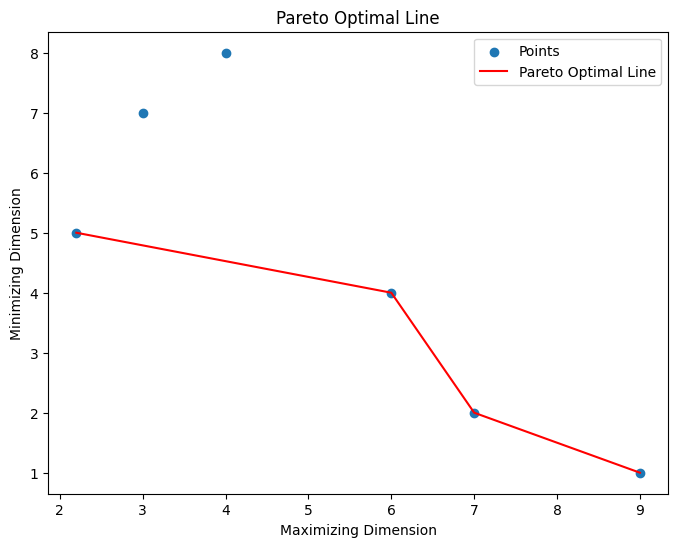

In [93]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pareto_optimal_line(data):
    # Sort the data based on the first dimension (maximizing)
    sorted_data = data[np.argsort(data[:, 0])]

    pareto_front = [sorted_data[0]]

    for point in sorted_data[1:]:
        if point[1] <= pareto_front[-1][1]:
            pareto_front.append(point)

    pareto_front = np.array(pareto_front)

    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], label='Points')
    plt.plot(pareto_front[:, 0], pareto_front[:, 1], color='red', label='Pareto Optimal Line')
    plt.xlabel('Maximizing Dimension')
    plt.ylabel('Minimizing Dimension')
    plt.title('Pareto Optimal Line')
    plt.legend()
    plt.show()

# Example data (replace this with your own data)
data = np.array([[4, 8], [7, 2], [2.2, 5], [9, 1], [6, 4], [3, 7]])
plot_pareto_optimal_line(data)

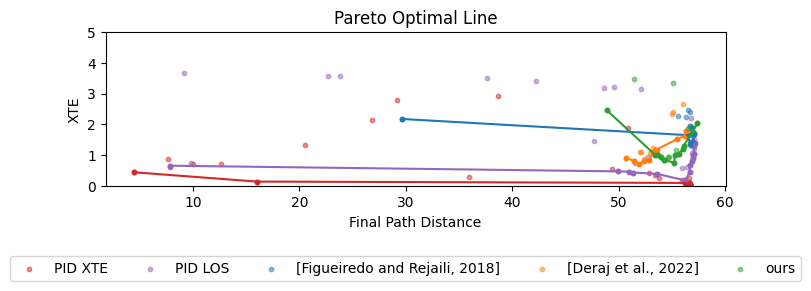

In [38]:
names = [
  '09-01-pid-los-scenario-1-*^indiv',
  '09-01-pid-los-scenario-1-indiv*',
]
labels = ['LOS', 'LOS-INDIV']

import pickle
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd

def plot_pareto_optimal_line(data, label=None, color=None):
  # Sort the data based on the first dimension (maximizing)
  sorted_data = data[np.argsort(data[:, 0])]
  pareto_front_left = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_left[-1][1]:
      pareto_front_left.append(point)

  sorted_data = data[np.argsort(data[:, 0])[::-1]]
  pareto_front_right = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_right[-1][1]:
      pareto_front_right.append(point)

  pareto_front = pareto_front_left[:-1] + pareto_front_right[::-1]
  pareto_front = np.array(pareto_front)
  plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.5, color=color)
  plt.scatter(pareto_front[:, 0], pareto_front[:, 1], s=10, color=color, label=label)
  plt.plot(pareto_front[:, 0], pareto_front[:, 1], color=color)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']


from collections import defaultdict
import re


# for file in tqdm(glob('../runs/09-01-pid-xte-scenario-1-indiv-*', recursive=True), desc='Loading data', leave=False):
#   deg = int(re.search(r'(\d+)deg', file).group(1))
#   files = glob(f'{file}/eval-*/0/*.csv')
#   assert len(files) == 1
#   df = pd.read_csv(files[0])
#   xte = df['obs/xte/0'].abs().mean()
#   dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
#   score_by_angle[deg].append([dist, xte])
score_by_type = defaultdict(list)
for file in tqdm(glob('../runs/09-01-pid-xte-scenario-1-*', recursive=True), desc='Loading data', leave=False):
  if 'indiv' in file:
    continue
  files = glob(f'{file}/eval-*')
  mean_xte = 0
  mean_dist = 0
  for file in files:
    deg = int(re.search(r'(\d+)deg', file).group(1))
    file = glob(f'{file}/0/*.csv')[0]
    df = pd.read_csv(file)
    xte = df['obs/xte/0'].abs().mean()
    dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
    mean_xte += xte
    mean_dist += dist
  mean_xte /= len(files)
  mean_dist /= len(files)
  score_by_type['PID XTE'].append([mean_dist, mean_xte])


# for file in tqdm(glob('../runs/09-01-pid-los-scenario-1-indiv-*', recursive=True), desc='Loading data', leave=False):
#   deg = int(re.search(r'(\d+)deg', file).group(1))
#   files = glob(f'{file}/eval-*/0/*.csv')
#   assert len(files) == 1
#   df = pd.read_csv(files[0])
#   xte = df['obs/xte/0'].abs().mean()
#   dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
#   score_by_angle[deg].append([dist, xte])

for file in tqdm(glob('../runs/09-01-pid-los-scenario-1-*', recursive=True), desc='Loading data', leave=False):
  if 'indiv' in file:
    continue
  files = glob(f'{file}/eval-*')
  mean_xte = 0
  mean_dist = 0
  for file in files:
    file = glob(f'{file}/0/*.csv')[0]
    df = pd.read_csv(file)
    xte = df['obs/xte/0'].abs().mean()
    dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
    mean_xte += xte
    mean_dist += dist
  mean_xte /= len(files)
  mean_dist /= len(files)
  score_by_type['PID LOS'].append([mean_dist, mean_xte])



# for file in tqdm(glob('../runs/09-01-pid-los-scenario-1-*', recursive=True), desc='Loading data', leave=False):
#   if 'indiv' in file:
#     continue
#   files = glob(f'{file}/eval-*')
#   mean_xte = 0
#   mean_dist = 0
#   for file in files:
#     deg = int(re.search(r'(\d+)deg', file).group(1))
#     files = glob(f'{file}/0/*.csv')
#     df = pd.read_csv(files[0])
#     xte = df['obs/xte/0'].abs().mean()
#     dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
#     mean_xte += xte
#     mean_dist += dist
#   mean_xte /= len(files)
#   mean_dist /= len(files)
#   score_by_type['PID LOS'].append([mean_dist, mean_xte])

names = [
  ('09-03-linear-shape-best-s1-1-*', '[Figueiredo and Rejaili, 2018]'),
  ('09-03-real-exp-shape-best-s1-1-*', '[Deraj et al., 2022]'),
  ('09-03-custom-shape-best-s1-1-*', 'ours'),
]
labels = ['sb3']


def plot_pareto_optimal_line(data, label=None, color=None):
  # Sort the data based on the first dimension (maximizing)
  sorted_data = data[np.argsort(data[:, 0])]
  pareto_front_left = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_left[-1][1]:
      pareto_front_left.append(point)

  sorted_data = data[np.argsort(data[:, 0])[::-1]]
  pareto_front_right = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] <= pareto_front_right[-1][1]:
      pareto_front_right.append(point)

  pareto_front = pareto_front_left[:-1] + pareto_front_right[::-1]
  pareto_front = np.array(pareto_front)
  plt.scatter(data[:, 0], data[:, 1], label=label, s=10, alpha=0.5, color=color)
  plt.scatter(pareto_front[:, 0], pareto_front[:, 1], s=10, color=color)
  plt.plot(pareto_front[:, 0], pareto_front[:, 1], color=color)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']


from collections import defaultdict
import re

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

for i, (name, label) in enumerate(names):
  files = glob(f'../runs/{name}', recursive=True)
  data = []
  for file in tqdm(files, desc=label, leave=False):
    mean_xte = 0
    mean_dist = 0
    envs = glob(f'{file}/eval-*/0/*.csv')
    if len(envs) == 0:
      continue
    for env in envs:
      try:
        df = pd.read_csv(env)
        mean_xte += np.abs(df["obs/xte/0"]).mean()
        mean_dist += df["obs/cum_obs/vmc/0"].iloc[-1]*.1
      except:
        continue
    mean_xte /= len(envs)
    mean_dist /= len(envs)
    score_by_type[label].append([mean_dist, mean_xte])




colors = ['C3', 'C4', 'C0', 'C1', 'C2', 'C5', 'C6']
fig = plt.figure(figsize=(8, 2))
for i, algo in enumerate(score_by_type):
  scores = np.array(score_by_type[algo])
  plot_pareto_optimal_line(scores, label=algo, color=f'{colors[i]}')
plt.ylim(0, 5)
plt.xlabel('Final Path Distance')
# plt.hlines(10, 0, 60, color='red', linestyle='--', label='Corridor')
plt.ylabel('XTE')
plt.title('Pareto Optimal Line')
fig.legend(loc='lower center',
            bbox_to_anchor=(.5, -.4),
            ncol=5)

plt.savefig(f'../09-01-pids-scenario-1-final.svg')


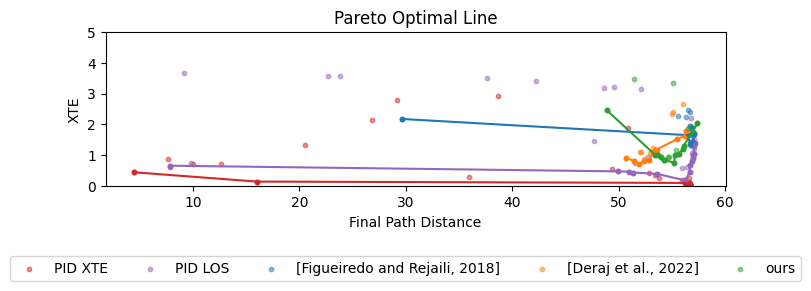

In [40]:
colors = ['C3', 'C4', 'C0', 'C1', 'C2', 'C5', 'C6']
fig = plt.figure(figsize=(8, 2))
for i, algo in enumerate(score_by_type):
  scores = np.array(score_by_type[algo])
  plot_pareto_optimal_line(scores, label=algo, color=f'{colors[i]}')
plt.ylim(0, 5)
plt.xlabel('Final Path Distance')
# plt.hlines(10, 0, 60, color='red', linestyle='--', label='Corridor')
plt.ylabel('XTE')
plt.title('Pareto Optimal Line')
fig.legend(loc='lower center',
            bbox_to_anchor=(.5, -.4),
            ncol=5)

plt.savefig(f'../09-01-pids-scenario-1-final-large.svg')

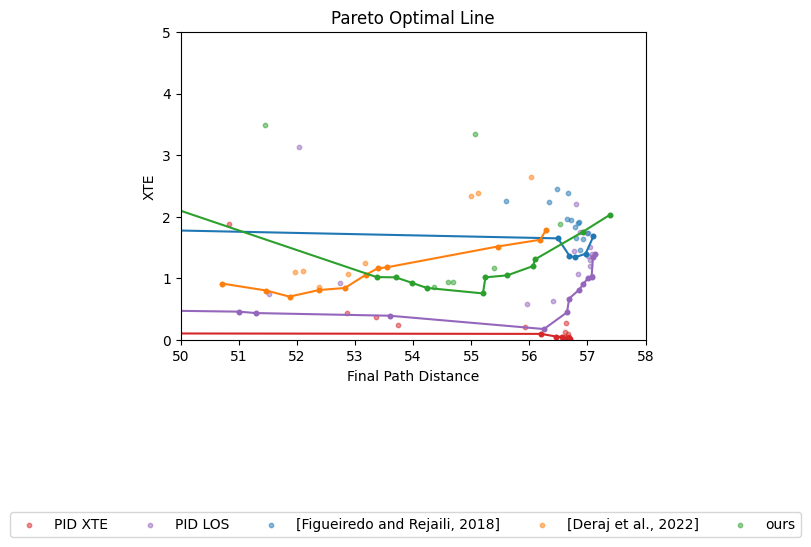

In [41]:
colors = ['C3', 'C4', 'C0', 'C1', 'C2', 'C5', 'C6']
fig = plt.figure(figsize=(6, 4))
for i, algo in enumerate(score_by_type):
  scores = np.array(score_by_type[algo])
  plot_pareto_optimal_line(scores, label=algo, color=f'{colors[i]}')
plt.xlim(50,58)
plt.ylim(0, 5)
plt.xlabel('Final Path Distance')
# plt.hlines(10, 0, 60, color='red', linestyle='--', label='Corridor')
plt.ylabel('XTE')
plt.title('Pareto Optimal Line')
fig.legend(loc='lower center',
            bbox_to_anchor=(.5, -.4),
            ncol=5)

plt.savefig(f'../09-01-pids-scenario-1-final-zoom.svg')


# -----

In [6]:
names = [
  '09-01-pid-los-scenario-1-*^indiv',
  '09-01-pid-los-scenario-1-indiv*',
]
labels = ['LOS', 'LOS-INDIV']

import pickle
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']


from collections import defaultdict
import re

run_id_by_score = {}

score_by_type = defaultdict(list)
for run_id in tqdm(glob('../runs/09-01-pid-xte-scenario-1-*', recursive=True), desc='Loading data', leave=False):
  if 'indiv' in run_id:
    continue
  files = glob(f'{run_id}/eval-*')
  mean_xte = 0
  mean_dist = 0
  for file in files:
    deg = int(re.search(r'(\d+)deg', file).group(1))
    file = glob(f'{file}/0/*.csv')[0]
    df = pd.read_csv(file)
    xte = df['obs/xte/0'].abs().mean()
    dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
    mean_xte += xte
    mean_dist += dist
  mean_xte /= len(files)
  mean_dist /= len(files)
  run_id_by_score[f'{mean_dist:.2},{mean_xte:.2}'] = run_id
  score_by_type['PID XTE'].append([mean_dist, mean_xte])
score_by_type['PID XTE'].append([0, 0])

for run_id in tqdm(glob('../runs/09-01-pid-los-scenario-1-*', recursive=True), desc='Loading data', leave=False):
  if 'indiv' in run_id:
    continue
  files = glob(f'{run_id}/eval-*')
  mean_xte = 0
  mean_dist = 0
  for file in files:
    file = glob(f'{file}/0/*.csv')[0]
    df = pd.read_csv(file)
    xte = df['obs/xte/0'].abs().mean()
    dist = df['obs/cum_obs/vmc/0'].iloc[-1]*.1
    mean_xte += xte
    mean_dist += dist
  mean_xte /= len(files)
  mean_dist /= len(files)
  run_id_by_score[f'{mean_dist:.2},{mean_xte:.2}'] = run_id
  score_by_type['PID LOS'].append([mean_dist, mean_xte])
score_by_type['PID LOS'].append([0, 0])

In [7]:
import pickle

pickle.dump(score_by_type, open('../score_by_type.pkl', 'wb'))

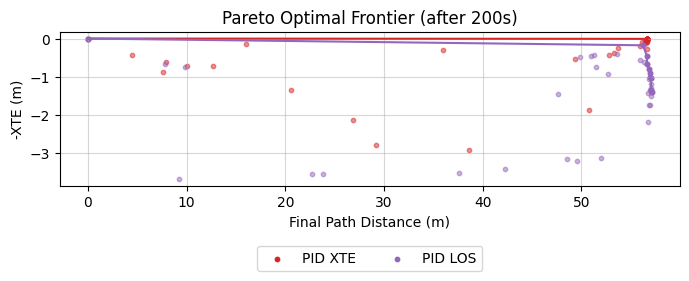

In [115]:
def plot_pareto_optimal_line(data, label=None, color=None):
  # Sort the data based on the first dimension (maximizing)
  sorted_data = data[np.argsort(data[:, 0])]
  pareto_front_left = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] >= pareto_front_left[-1][1]:
      pareto_front_left.append(point)

  sorted_data = data[np.argsort(data[:, 0])[::-1]]
  pareto_front_right = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] >= pareto_front_right[-1][1]:
      pareto_front_right.append(point)

  pareto_front = pareto_front_left[:-1] + pareto_front_right[::-1]
  pareto_front = np.array(pareto_front)
  plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.5, color=color)
  plt.scatter(pareto_front[:, 0], pareto_front[:, 1], s=10, color=color, label=label)
  plt.plot(pareto_front[:, 0], pareto_front[:, 1], color=color)
  return pareto_front

front_by_type = {}

colors = ['C3', 'C4', 'C0', 'C1', 'C2', 'C5', 'C6']
fig = plt.figure(figsize=(8, 2))
for i, algo in enumerate(score_by_type):
  scores = np.array(score_by_type[algo])
  scores[:, 1] *= -1
  pareto_front = plot_pareto_optimal_line(scores, label=algo, color=f'{colors[i]}')
  front_by_type[algo] = pareto_front
# plt.ylim(-5, 0)
# plt.xlim(0)
plt.grid(alpha=0.5)
plt.xlabel('Final Path Distance (m)')
plt.ylabel('-XTE (m)')
plt.title('Pareto Optimal Frontier (after 200s)')
plt.legend(loc='lower center',
            bbox_to_anchor=(.5, -.6),
            ncol=5)
# plt.suplot
# plt.tight_layout()

plt.savefig(f'../slides/PID-vs-LOS.pdf', bbox_inches='tight')

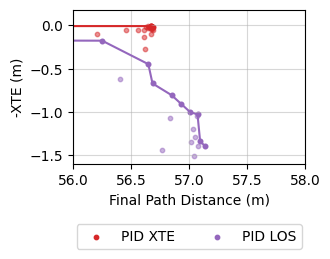

In [116]:
def plot_pareto_optimal_line(data, label=None, color=None):
  # Sort the data based on the first dimension (maximizing)
  sorted_data = data[np.argsort(data[:, 0])]
  pareto_front_left = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] >= pareto_front_left[-1][1]:
      pareto_front_left.append(point)

  sorted_data = data[np.argsort(data[:, 0])[::-1]]
  pareto_front_right = [sorted_data[0]]
  for point in sorted_data[1:]:
    if point[1] >= pareto_front_right[-1][1]:
      pareto_front_right.append(point)

  pareto_front = pareto_front_left[:-1] + pareto_front_right[::-1]
  pareto_front = np.array(pareto_front)
  plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.5, color=color)
  plt.scatter(pareto_front[:, 0], pareto_front[:, 1], s=10, color=color, label=label)
  plt.plot(pareto_front[:, 0], pareto_front[:, 1], color=color)
  return pareto_front

front_by_type = {}

colors = ['C3', 'C4', 'C0', 'C1', 'C2', 'C5', 'C6']
fig = plt.figure(figsize=(3, 2))
for i, algo in enumerate(score_by_type):
  scores = np.array(score_by_type[algo])
  scores[:, 1] *= -1
  pareto_front = plot_pareto_optimal_line(scores, label=algo, color=f'{colors[i]}')
  front_by_type[algo] = pareto_front
plt.xlim(56, 58)
plt.ylim(-1.6)
plt.grid(alpha=0.5)
plt.xlabel('Final Path Distance (m)')
plt.ylabel('-XTE (m)')
# plt.tight_layout()
# plt.title('Pareto Optimal Frontier (after 200s)')
plt.legend(loc='lower center',
            bbox_to_anchor=(.5, -.6),
            ncol=5)

plt.savefig(f'../slides/PID-vs-LOS-zoom.pdf', bbox_inches='tight')

In [28]:
front_by_type['PID LOS']

array([[ 7.81077726, -0.65705764],
       [49.890949  , -0.473618  ],
       [51.001937  , -0.45930464],
       [51.29726071, -0.43623811],
       [53.59618071, -0.39329196],
       [56.25174714, -0.17699852],
       [56.64876957, -0.44880843],
       [56.68474514, -0.67217828],
       [56.850524  , -0.80943155],
       [56.93180929, -0.91026471],
       [57.01050229, -1.0062533 ],
       [57.07183471, -1.02985564],
       [57.09440114, -1.34283237],
       [57.13448957, -1.39530984]])

In [139]:
front_by_type['PID XTE']

array([[ 0.00000000e+00, -0.00000000e+00],
       [ 5.66701627e+01, -8.03582518e-03],
       [ 5.66703527e+01, -8.99471626e-03],
       [ 5.66811101e+01, -1.45277913e-02],
       [ 5.66918529e+01, -2.02346826e-02]])

In [140]:
dist, xte = [56.25174714, -0.17699852]
print(run_id_by_score[f'{dist:.2},{-xte:.2}'])
dist, xte = [57.13448957, -1.39530984]
print(run_id_by_score[f'{dist:.2},{-xte:.2}'])
dist, xte = [5.66918529e+01, -2.02346826e-02]
print(run_id_by_score[f'{dist:.2},{-xte:.2}'])

../runs/09-01-pid-los-scenario-1-9
../runs/09-01-pid-los-scenario-1-29
../runs/09-01-pid-xte-scenario-1-31


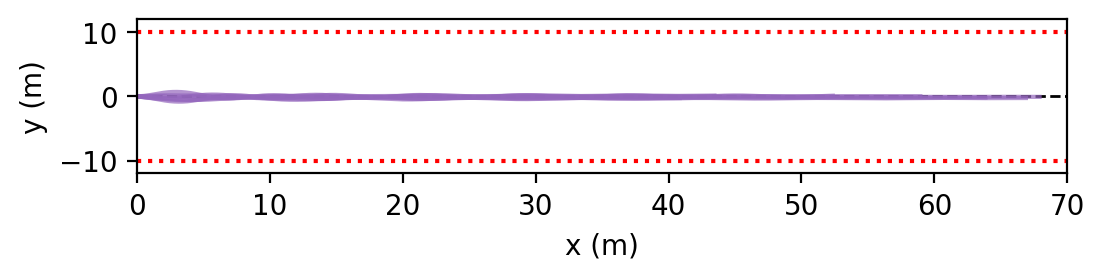

In [153]:
names = [
  ('09-01-pid-los-scenario-1-9/eval-*/0/', 'PID 1'),
  # ('09-01-pid-los-scenario-1-29/eval-*/0/', 'PID 1'),
  # ('09-01-pid-los-scenario-1-29/eval-*-135deg/0/', 'PID 1'),
]

xte_delta = 10

fig, ax = plt.subplots(figsize=(6, 1), dpi=200)

ax.plot([0, 200], [0, 0], 'k--', label='Reference path', linewidth=1)
ax.plot([0, 200], [xte_delta, xte_delta], 'r:', label='XTE > 10m')

ax.plot([0, 200], [-xte_delta, -xte_delta], 'r:')
for i, (name, label) in enumerate(names):
  color = f'C4'
  files = glob(f'../runs/{name}/*.csv', recursive=True)
  for file in files:
    try:
      df = pd.read_csv(file)
      ax.plot(df["obs/p_boat/0"], df["obs/p_boat/1"],
            alpha=0.7, color=color, linewidth=1.5)
    except:
      continue

for i, (_, label) in enumerate(names):
  ax.plot([], [], color=f'C{i}', label=label)


ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim(0, 70)
ax.set_ylim(-xte_delta * 1.2, xte_delta * 1.2)
# fig.legend(loc='lower center',
#             bbox_to_anchor=(.5, -.1),
#             ncol=2)
fig.savefig('../slides/LOS-1.pdf', bbox_inches='tight')


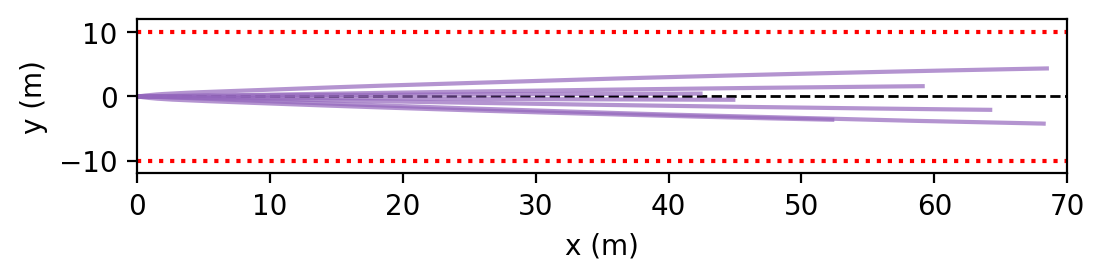

In [14]:
names = [
#   ('09-01-pid-los-scenario-1-9/eval-*/0/', 'PID 1'),
  ('09-01-pid-los-scenario-1-29/eval-*/0/', 'PID 1'),
  # ('09-01-pid-los-scenario-1-29/eval-*-135deg/0/', 'PID 1'),
]

xte_delta = 10

fig, ax = plt.subplots(figsize=(6, 1), dpi=200)

ax.plot([0, 200], [0, 0], 'k--', label='Reference path', linewidth=1)
ax.plot([0, 200], [xte_delta, xte_delta], 'r:', label='XTE > 10m')

ax.plot([0, 200], [-xte_delta, -xte_delta], 'r:')
for i, (name, label) in enumerate(names):
  color = f'C4'
  files = glob(f'../runs/{name}/*.csv', recursive=True)
  for file in files:
    try:
      df = pd.read_csv(file)
      ax.plot(df["obs/p_boat/0"], df["obs/p_boat/1"],
            alpha=0.7, color=color, linewidth=1.5)
    except:
      continue

for i, (_, label) in enumerate(names):
  ax.plot([], [], color=f'C{i}', label=label)


ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim(0, 70)
ax.set_ylim(-xte_delta * 1.2, xte_delta * 1.2)
# fig.legend(loc='lower center',
#             bbox_to_anchor=(.5, -.1),
#             ncol=2)
fig.savefig('../slides/LOS-2.pdf', bbox_inches='tight')


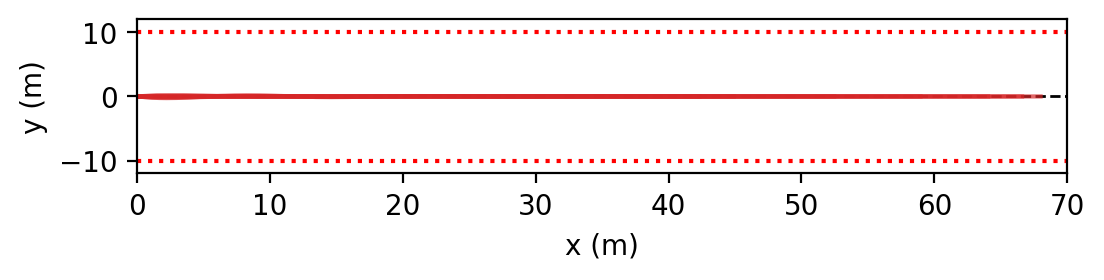

In [159]:
names = [
  ('09-01-pid-xte-scenario-1-31/eval-*/0/', 'PID 1'),
#   ('09-01-pid-los-scenario-1-29/eval-*/0/', 'PID 1'),
  # ('09-01-pid-los-scenario-1-29/eval-*-135deg/0/', 'PID 1'),
]

xte_delta = 10

fig, ax = plt.subplots(figsize=(6, 1), dpi=200)

ax.plot([0, 200], [0, 0], 'k--', label='Reference path', linewidth=1)
ax.plot([0, 200], [xte_delta, xte_delta], 'r:', label='XTE > 10m')

ax.plot([0, 200], [-xte_delta, -xte_delta], 'r:')
for i, (name, label) in enumerate(names):
  color = f'C3'
  files = glob(f'../runs/{name}/*.csv', recursive=True)
  for file in files:
    try:
      df = pd.read_csv(file)
      ax.plot(df["obs/p_boat/0"], df["obs/p_boat/1"],
            alpha=0.7, color=color, linewidth=1.5)
    except:
      continue

for i, (_, label) in enumerate(names):
  ax.plot([], [], color=f'C{i}', label=label)


ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim(0, 70)
ax.set_ylim(-xte_delta * 1.2, xte_delta * 1.2)
# fig.legend(loc='lower center',
#             bbox_to_anchor=(.5, -.1),
#             ncol=2)
fig.savefig('../slides/XTE-1.pdf', bbox_inches='tight')


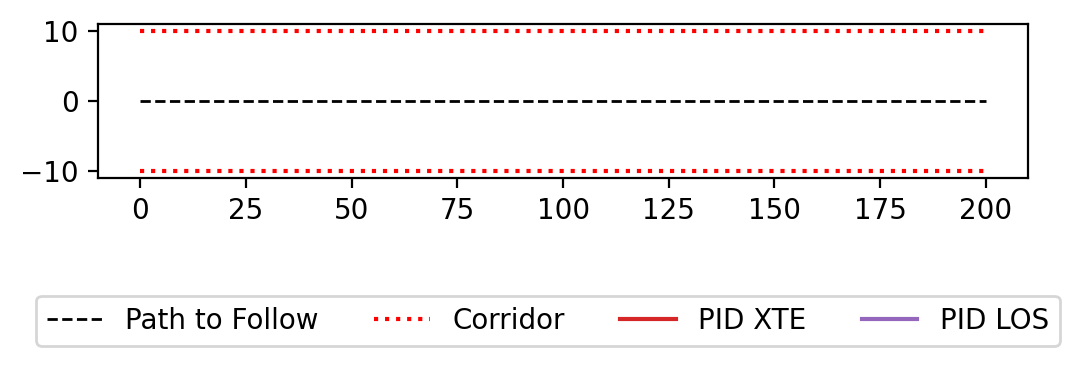

In [162]:
# names = [
#   ('09-01-pid-xte-scenario-1-31/eval-*/0/', 'PID 1'),
# #   ('09-01-pid-los-scenario-1-29/eval-*/0/', 'PID 1'),
#   # ('09-01-pid-los-scenario-1-29/eval-*-135deg/0/', 'PID 1'),
# ]

# xte_delta = 10

fig, ax = plt.subplots(figsize=(6, 1), dpi=200)

ax.plot([0, 200], [0, 0], 'k--', label='Path to Follow', linewidth=1)
ax.plot([0, 200], [xte_delta, xte_delta], 'r:', label='Corridor')

ax.plot([0, 200], [-xte_delta, -xte_delta], 'r:')
# for i, (name, label) in enumerate(names):
#   color = f'C3'
#   files = glob(f'../runs/{name}/*.csv', recursive=True)
#   for file in files:
#     try:
#       df = pd.read_csv(file)
#       ax.plot(df["obs/p_boat/0"], df["obs/p_boat/1"],
#             alpha=0.7, color=color, linewidth=1.5)
#     except:
#       continue

# for i, (_, label) in enumerate(names):
ax.plot([], [], color=f'C3', label='PID XTE')
ax.plot([], [], color=f'C4', label='PID LOS')


# ax.set_xlabel('x (m)')
# ax.set_ylabel('y (m)')
# ax.set_xlim(0, 70)
# ax.set_ylim(-xte_delta * 1.2, xte_delta * 1.2)
fig.legend(loc='lower center',
            bbox_to_anchor=(.5, -.8),
            ncol=4)
fig.savefig('../slides/LOS-vs-XTE-legend.pdf', bbox_inches='tight')


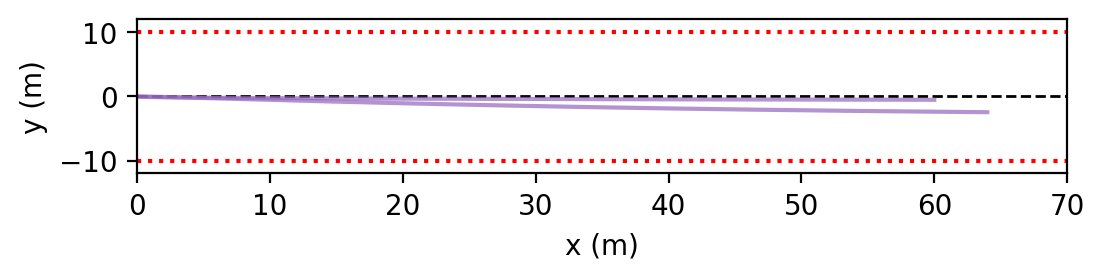

In [29]:
names = [
  ('09-01-pid-los-scenario-1-11/eval-*-270deg/0/', 'PID 1'),
  ('09-01-pid-los-scenario-1-5/eval-*-270deg/0/', 'PID 1'),
]

xte_delta = 10

fig, ax = plt.subplots(figsize=(6, 1), dpi=200)

ax.plot([0, 200], [0, 0], 'k--', label='Reference path', linewidth=1)
ax.plot([0, 200], [xte_delta, xte_delta], 'r:', label='XTE > 10m')

ax.plot([0, 200], [-xte_delta, -xte_delta], 'r:')
for i, (name, label) in enumerate(names):
  color = f'C4'
  files = glob(f'../runs/{name}/*.csv', recursive=True)
  for file in files:
    try:
      df = pd.read_csv(file)
      ax.plot(df["obs/p_boat/0"], df["obs/p_boat/1"],
            alpha=0.7, color=color, linewidth=1.5)
    except:
      continue

for i, (_, label) in enumerate(names):
  ax.plot([], [], color=f'C{i}', label=label)


ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim(0, 70)
ax.set_ylim(-xte_delta * 1.2, xte_delta * 1.2)
fig.savefig('../slides/multicriteria.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


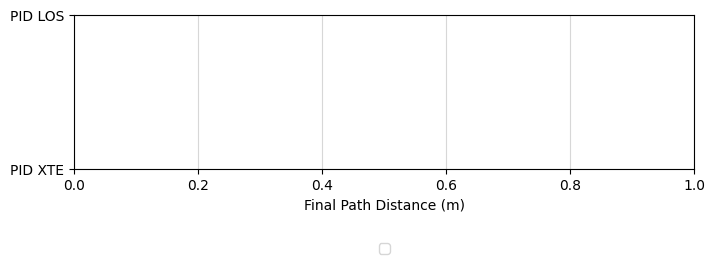

In [5]:
colors = ['C3', 'C4', 'C0', 'C1', 'C2', 'C5', 'C6']
fig = plt.figure(figsize=(8, 2))
score_by_type = {}
for i, algo in enumerate(score_by_type):
  scores = np.array(score_by_type[algo])
  dist = scores[:, 0]
  plt.vlines(dist.max(), 0, 1, color=colors[i], alpha=1)
  plt.scatter(dist, (dist*0 + i), s=15, alpha=0.5, color=colors[i])
  plt.scatter(dist.max(), i, s=15, color=colors[i], label=algo)
plt.yticks([1,0], ['PID LOS','PID XTE'])
#   scores[:, 1] *= -1
#   pareto_front = plot_pareto_optimal_line(scores, label=algo, color=f'{colors[i]}')
#   front_by_type[algo] = pareto_front
# plt.ylim(-5, 0)
# plt.xlim(0)
plt.grid(alpha=0.5)
plt.xlabel('Final Path Distance (m)')
# plt.ylabel('-XTE (m)')
# plt.title('Pareto Optimal Frontier (after 200s)')
plt.legend(loc='lower center',
            bbox_to_anchor=(.5, -.6),
            ncol=5)
# # plt.suplot
# # plt.tight_layout()

plt.savefig(f'../slides/PID-vs-LOS-1D.pdf', bbox_inches='tight')

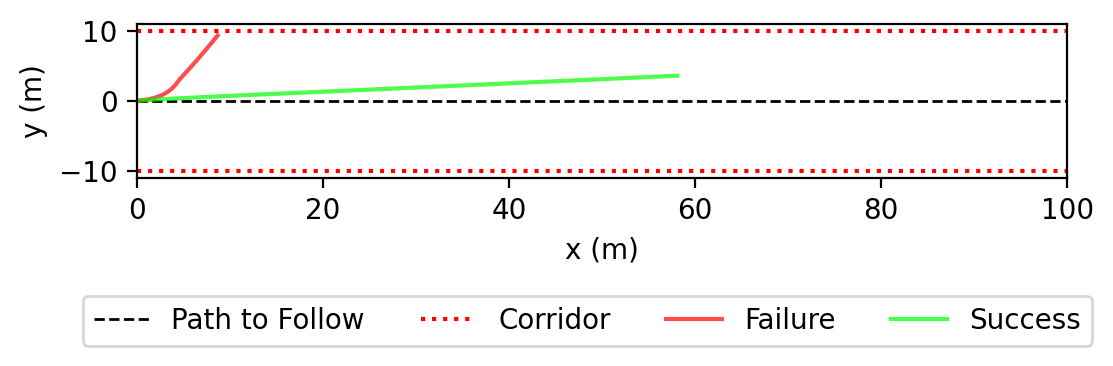

In [97]:

fig, ax = plt.subplots(figsize=(6, 1), dpi=200)
xte_delta = 10

ax.plot([0, 200], [0, 0], 'k--', label='Path to Follow', linewidth=1)
ax.plot([0, 200], [xte_delta, xte_delta], 'r:', label='Corridor')

ax.plot([0, 200], [-xte_delta, -xte_delta], 'r:')
# for i, (name, label) in enumerate(names):
#   color = f'C3'
#   files = glob(f'../runs/{name}/*.csv', recursive=True)
#   for file in files:
#     try:
#       df = pd.read_csv(file)
#     except:
#       continue

df = pd.read_csv(glob('../runs/09-07-pid-Kd-6/eval-*/0/*.csv')[0])
ax.plot(df["obs/p_boat/0"], df["obs/p_boat/1"],
    alpha=0.7, color='#F00', linewidth=1.5, label='Failure')

df = pd.read_csv(glob('../runs/09-07-pid-Kd-2/eval-*/0/*.csv')[0])
ax.plot(df["obs/p_boat/0"], df["obs/p_boat/1"],
    alpha=0.7, color='#0F0', linewidth=1.5, label='Success')

theta_heading = df["obs/theta_boat/2"].iloc[-1]
last_pos = df["obs/p_boat/0"].iloc[-1], df["obs/p_boat/1"].iloc[-1]

# ax.quiver(last_pos[0], last_pos[1], np.cos(theta_heading), np.sin(theta_heading), color='#00F', scale=20, width=0.005, alpha=0.7)


# for i, (_, label) in enumerate(names):
# ax.plot([], [], color=f'C4', label='PID LOS')


ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim(0, 100)
# ax.set_ylim(-xte_delta * 1.2, xte_delta * 1.2)
fig.legend(loc='lower center',
            bbox_to_anchor=(.5, -.8),
            ncol=4)
fig.savefig('../slides/protocol.pdf', bbox_inches='tight')


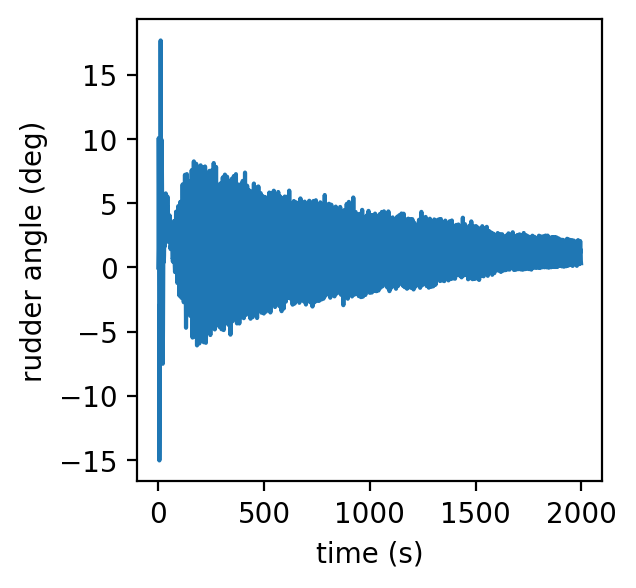

In [84]:
plt.figure(figsize=(3,3), dpi=200)
plt.xlabel('time (s)')
plt.ylabel('rudder angle (deg)')

plt.plot(np.rad2deg(df['act/theta_rudder/0'].values))

plt.savefig('../slides/PID-D-extra.pdf', bbox_inches='tight')

<Axes: >

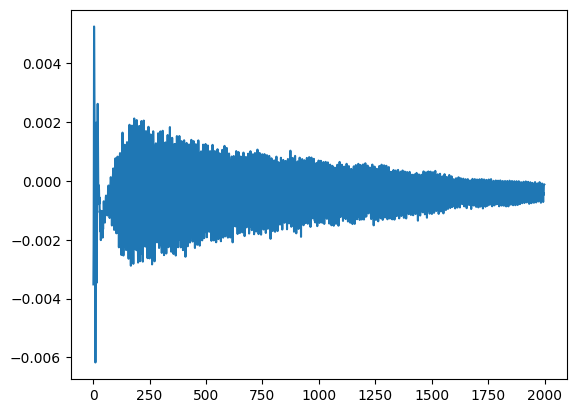

In [78]:
df['obs/xte/0'].diff().plot()

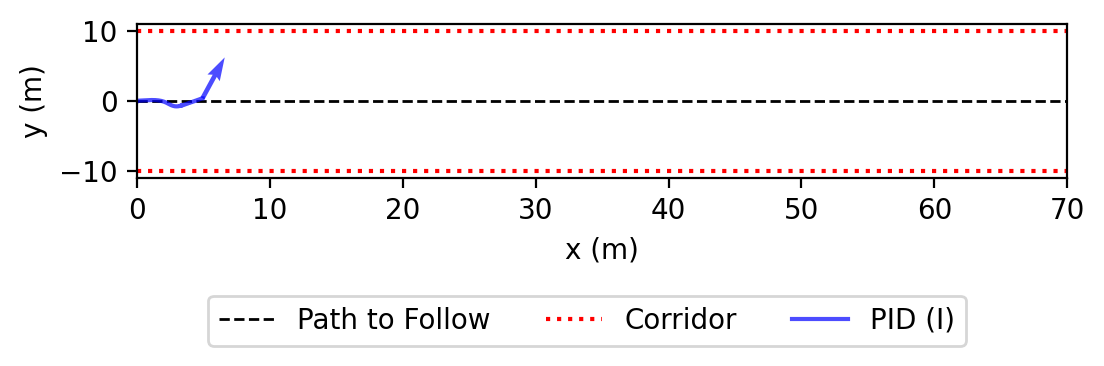

In [87]:
df = pd.read_csv(glob('../runs/09-07-pid-Ki-2/eval-*/0/*.csv')[0])

fig, ax = plt.subplots(figsize=(6, 1), dpi=200)
xte_delta = 10

ax.plot([0, 200], [0, 0], 'k--', label='Path to Follow', linewidth=1)
ax.plot([0, 200], [xte_delta, xte_delta], 'r:', label='Corridor')

ax.plot([0, 200], [-xte_delta, -xte_delta], 'r:')
# for i, (name, label) in enumerate(names):
#   color = f'C3'
#   files = glob(f'../runs/{name}/*.csv', recursive=True)
#   for file in files:
#     try:
#       df = pd.read_csv(file)
#     except:
#       continue

ax.plot(df["obs/p_boat/0"], df["obs/p_boat/1"],
    alpha=0.7, color='#00F', linewidth=1.5, label='PID (I)')

theta_heading = df["obs/theta_boat/2"].iloc[-1]
last_pos = df["obs/p_boat/0"].iloc[-1], df["obs/p_boat/1"].iloc[-1]

ax.quiver(last_pos[0], last_pos[1], np.cos(theta_heading), np.sin(theta_heading), color='#00F', scale=20, width=0.005, alpha=0.7)


# for i, (_, label) in enumerate(names):
# ax.plot([], [], color=f'C4', label='PID LOS')


ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim(0, 70)
# ax.set_ylim(-xte_delta * 1.2, xte_delta * 1.2)
fig.legend(loc='lower center',
            bbox_to_anchor=(.5, -.8),
            ncol=4)
fig.savefig('../slides/PID-I.pdf', bbox_inches='tight')


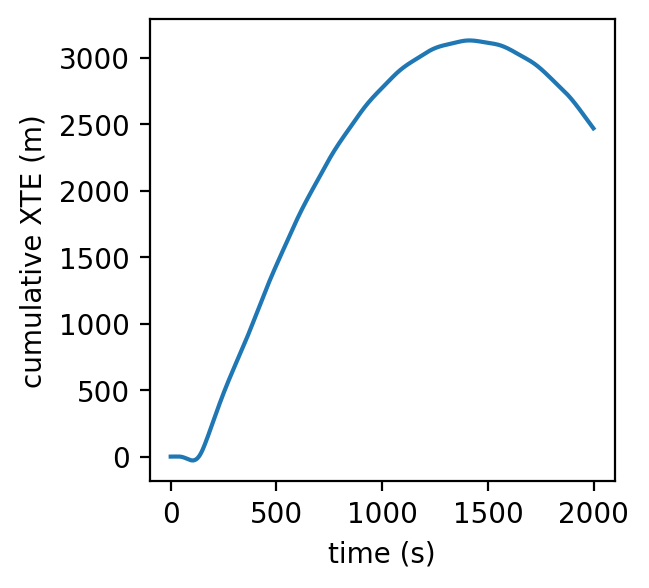

In [91]:
plt.figure(figsize=(3,3), dpi=200)
plt.xlabel('time (s)')
plt.ylabel('cumulative XTE (m)')

plt.plot(np.rad2deg(df['obs/cum_obs/xte/0'].values * .1))

plt.savefig('../slides/PID-I-extra.pdf', bbox_inches='tight')

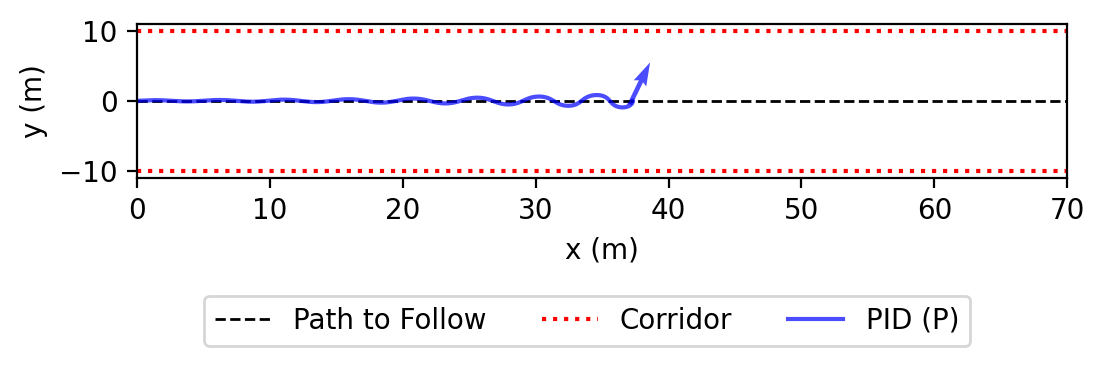

In [56]:
df = pd.read_csv(glob('../runs/09-07-pid-Kp-2/eval-*/0/*.csv')[0])

fig, ax = plt.subplots(figsize=(6, 1), dpi=200)
xte_delta = 10

ax.plot([0, 200], [0, 0], 'k--', label='Path to Follow', linewidth=1)
ax.plot([0, 200], [xte_delta, xte_delta], 'r:', label='Corridor')

ax.plot([0, 200], [-xte_delta, -xte_delta], 'r:')
# for i, (name, label) in enumerate(names):
#   color = f'C3'
#   files = glob(f'../runs/{name}/*.csv', recursive=True)
#   for file in files:
#     try:
#       df = pd.read_csv(file)
#     except:
#       continue

ax.plot(df["obs/p_boat/0"], df["obs/p_boat/1"],
    alpha=0.7, color='#00F', linewidth=1.5, label='PID (P)')

theta_heading = df["obs/theta_boat/2"].iloc[-1]
last_pos = df["obs/p_boat/0"].iloc[-1], df["obs/p_boat/1"].iloc[-1]

ax.quiver(last_pos[0], last_pos[1], np.cos(theta_heading), np.sin(theta_heading), color='#00F', scale=20, width=0.005, alpha=0.7)


# for i, (_, label) in enumerate(names):
# ax.plot([], [], color=f'C4', label='PID LOS')


ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim(0, 70)
# ax.set_ylim(-xte_delta * 1.2, xte_delta * 1.2)
fig.legend(loc='lower center',
            bbox_to_anchor=(.5, -.8),
            ncol=4)
fig.savefig('../slides/PID-P.pdf', bbox_inches='tight')

In [21]:
files = glob('../runs/09-01-pid-xte-scenario-1-*/eval.py/0/*.csv')

selected = []
for file in files[1:]:
    df = pd.read_csv(file, sep=',')
    print(file)
    break

df

../runs/09-01-pid-xte-scenario-1-1/eval.py/0/progress.csv


hyperparams/wind  \
scenario_1 09-01-pid-xte-scenario-1-0- 09-01-pid-xte-scenario-1-1 0 90 SailboatLSAEnv-v0 mss1-ode max_dist 200 True {'path': [[0, 0], [100, 0]], 'full_obs': True} 0.025252 0.0 1 0.005799 0.003885 xte scenario_1 90  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN               NaN   
                                                                                                                                                                                                                   225 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN               NaN   
                                                                                                                                                                                                                   270 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN               NaN   
                                                                                                                                                                                                                   135 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN               NaN   
                                                                                                                                                                                                                   315 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN               NaN   
                                                                                                                                                                                                                   180 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN               NaN   
                                                                                                                                                                                                                   45  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN N

In [24]:
df = pd.read_csv(file, index_col=0)
df

ParserError: Could not construct index. Requested to use 1 number of columns, but 114 left to parse.

In [20]:
study = optuna.load_study(study_name='09-01-pid-xte-scenario-1-31', storage='sqlite:///optuna.linear+exp.db')

array([nan, nan, nan, nan, nan, nan, nan])

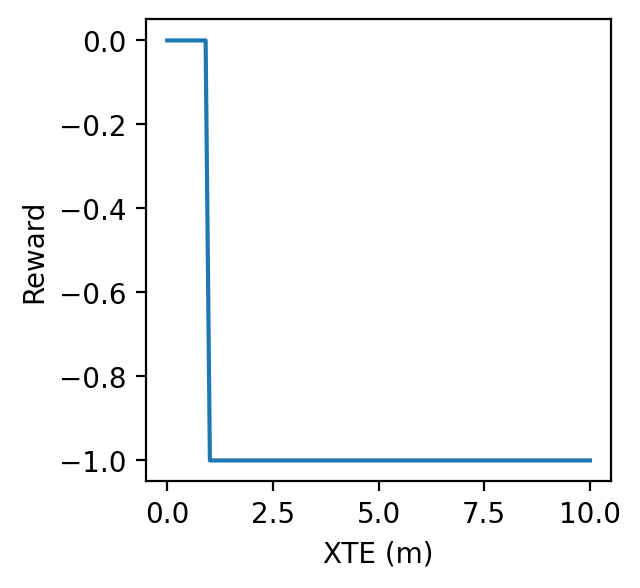

In [6]:
plt.figure(figsize=(3,3), dpi=200)
xte = np.linspace(0, 10, 100)
r = (xte <= 1) * 0 - (xte > 1) * 1
plt.plot(xte, r)
plt.xlabel('XTE (m)')
plt.ylabel('Reward')
plt.savefig('../slides/reward-xte-discontinuous.pdf', bbox_inches='tight')

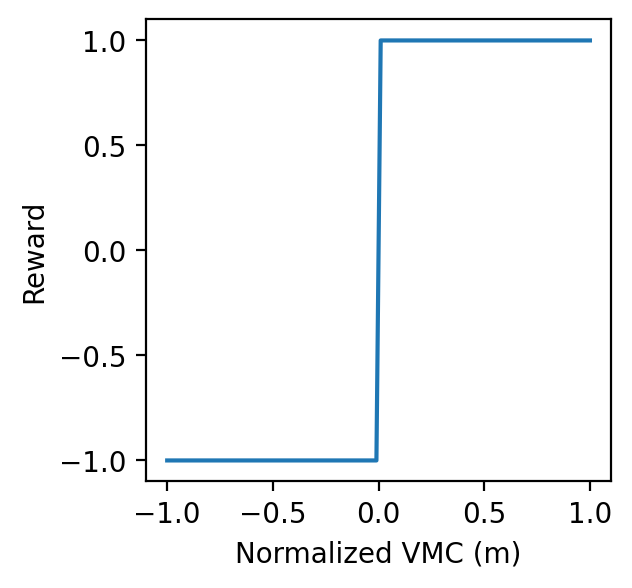

In [7]:
plt.figure(figsize=(3,3), dpi=200)
vmc = np.linspace(-1, 1, 100)
r = (vmc > 0) * 1 - (vmc < 0) * 1
plt.plot(vmc, r)
plt.xlabel('Normalized VMC (m)')
plt.ylabel('Reward')
plt.savefig('../slides/reward-vmc-discontinuous.pdf', bbox_inches='tight')